In [1]:
import os
import pandas as pd
import scanpy as sc
import numpy as np

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

2025-03-20 13:49:37.651791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-20 13:49:39.163060: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


scanpy==1.10.4 anndata==0.11.3 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.3 scikit-learn==1.4.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.12


In [2]:
ADATA_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/data/pbmc_adata.h5ad'
results_file = '/work/hdd/bbjr/mallina1/scanpy_results.h5ad'
GENE_INFO_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/gene_info.tsv'

In [3]:
adata = sc.read_h5ad(ADATA_FP)

/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
# print(adata.var_names)
# adata.var_names_make_unique()
# print(adata.var_names)

In [4]:
# gene IDs, gene symbols, useful maps
model_var_names = np.asarray(adata.var_names)
model_var_names_set = set(model_var_names)
var_name_to_index_map = {var_name: i for i, var_name in enumerate(model_var_names)}

gene_info_tsv_path = os.path.join(GENE_INFO_FP)
gene_info_df = pd.read_csv(gene_info_tsv_path, sep="\t")

gene_symbol_to_gene_id_map = dict()
for gene_symbol, gene_id in zip(gene_info_df['Gene Symbol'], gene_info_df['ENSEMBL Gene ID']):
    if gene_symbol != float('nan'):
        gene_symbol_to_gene_id_map[gene_symbol] = gene_id

gene_id_to_gene_symbol_map = {gene_id: gene_symbol for gene_symbol, gene_id in gene_symbol_to_gene_id_map.items()}
for gene_id in model_var_names:
    if gene_id not in gene_id_to_gene_symbol_map:
        gene_id_to_gene_symbol_map[gene_id] = gene_id

In [5]:
adata

AnnData object with n_obs × n_vars = 30495 × 33694
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method'
    var: 'gene_symbols'
    uns: 'CellType_colors', 'Method_colors'
    obsm: 'X_harmony'

normalizing counts per cell


    finished (0:00:00)


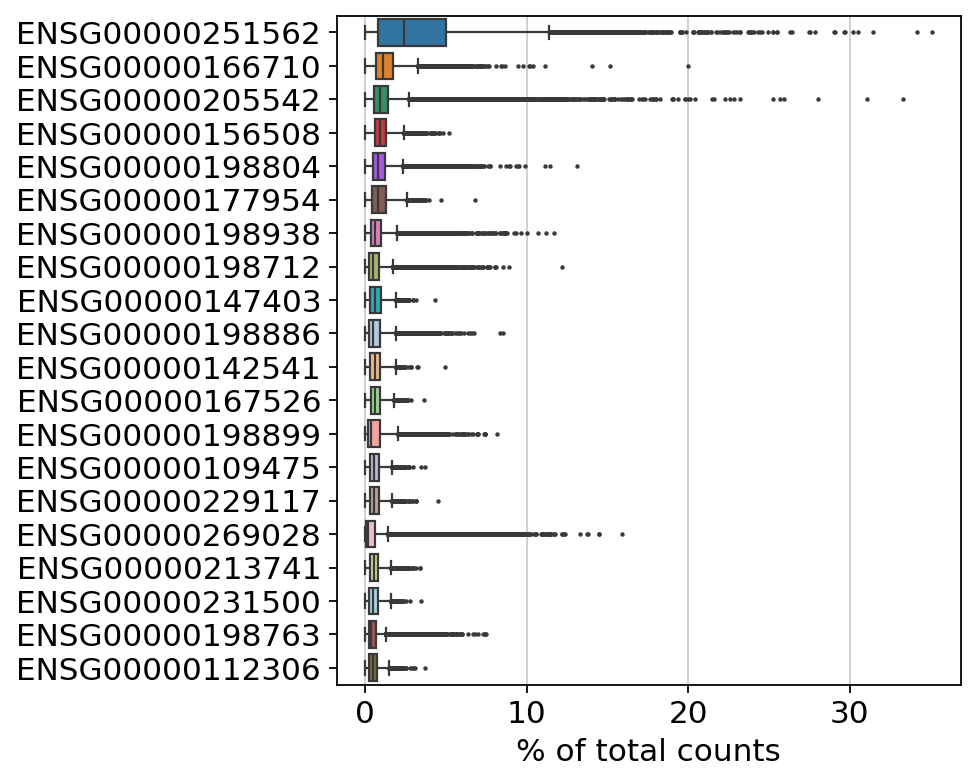

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20)

normalizing counts per cell
    finished (0:00:00)


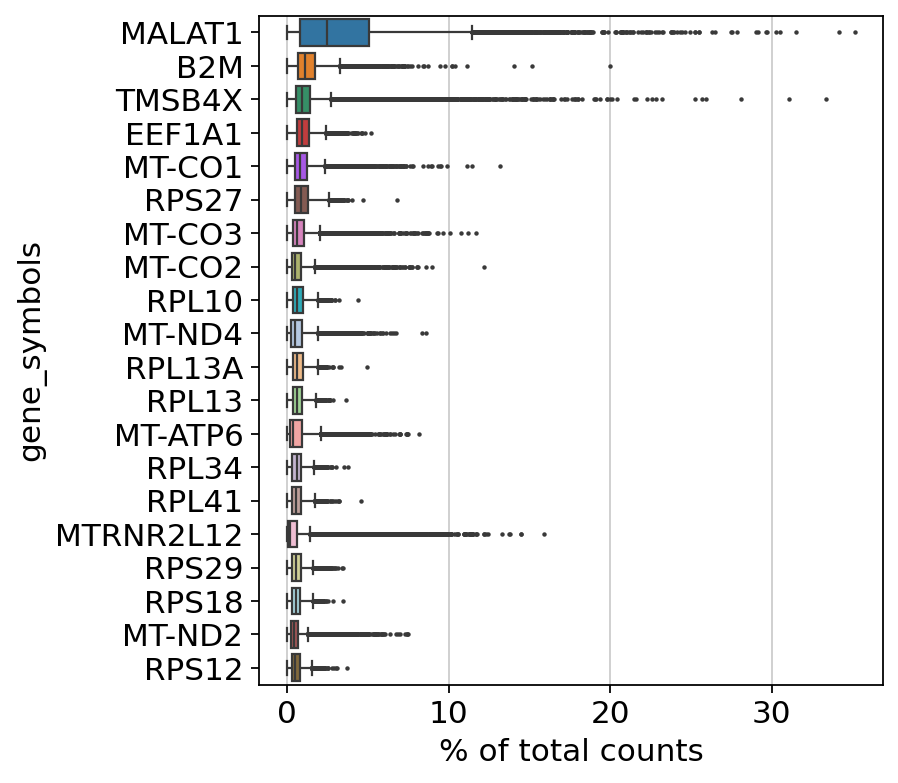

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, gene_symbols='gene_symbols')

In [22]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 2035 cells that have less than 200 genes expressed
filtered out 9096 genes that are detected in less than 3 cells


In [23]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

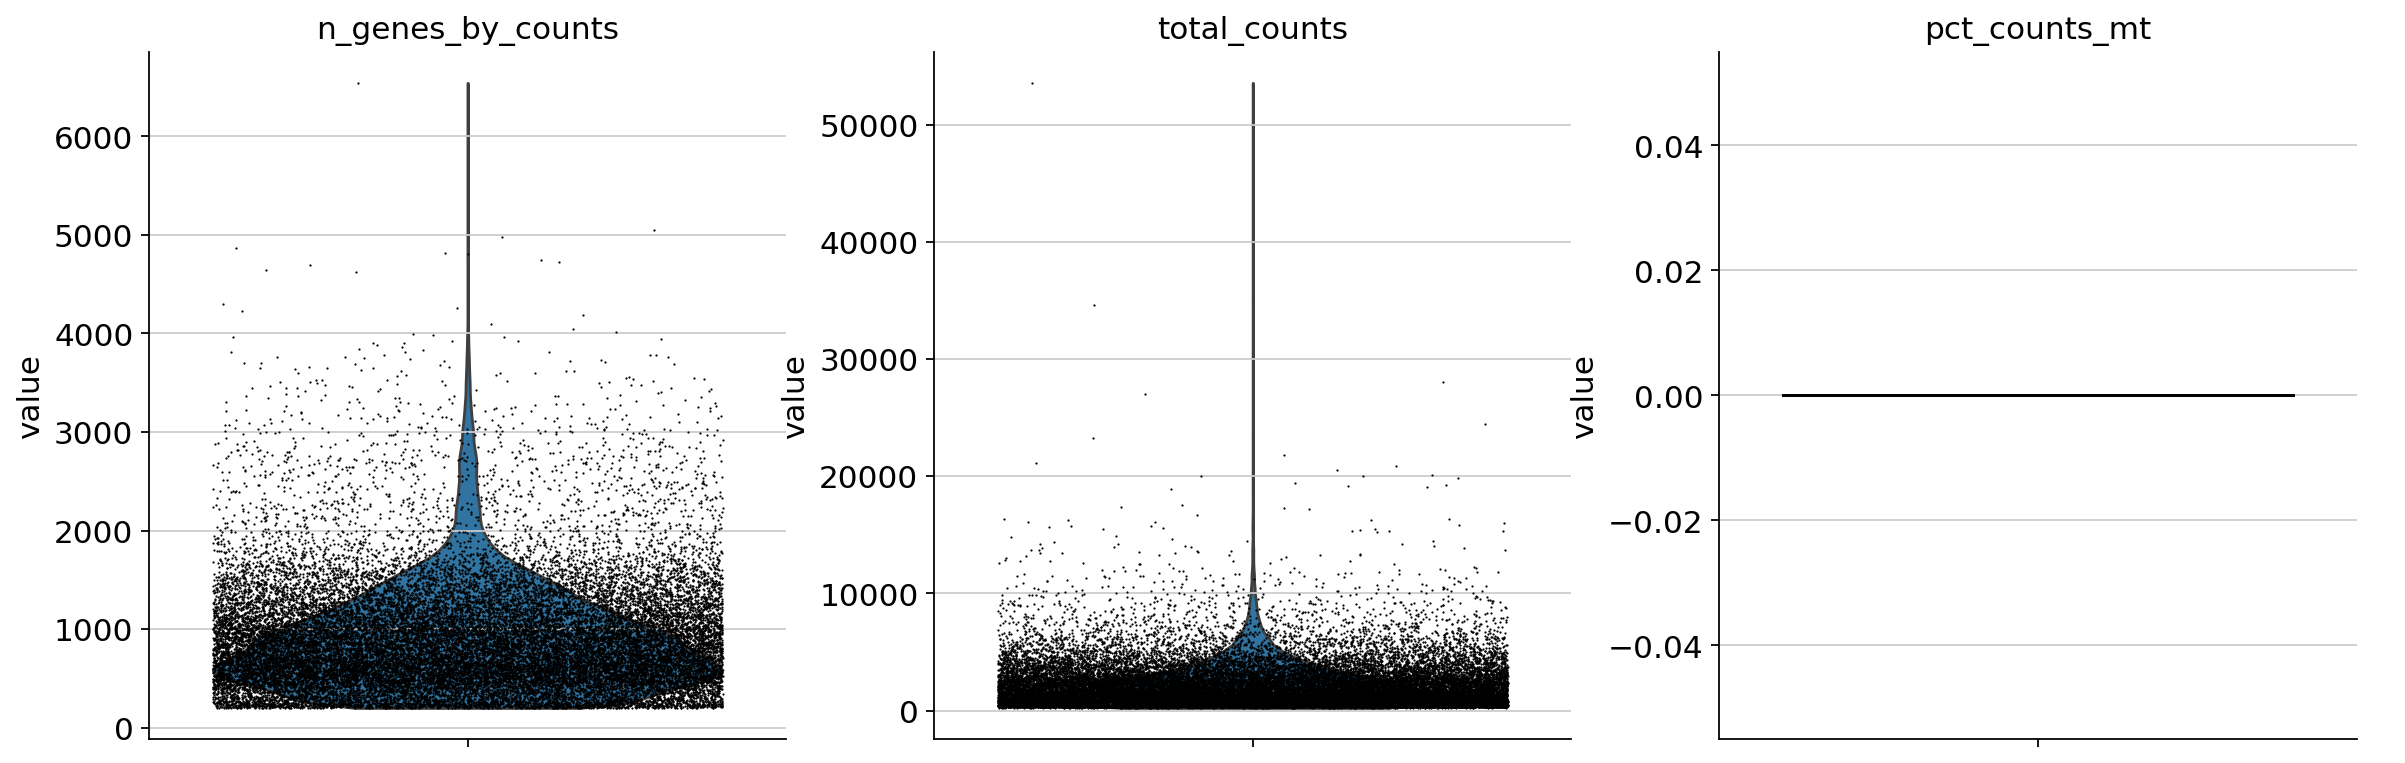

In [24]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

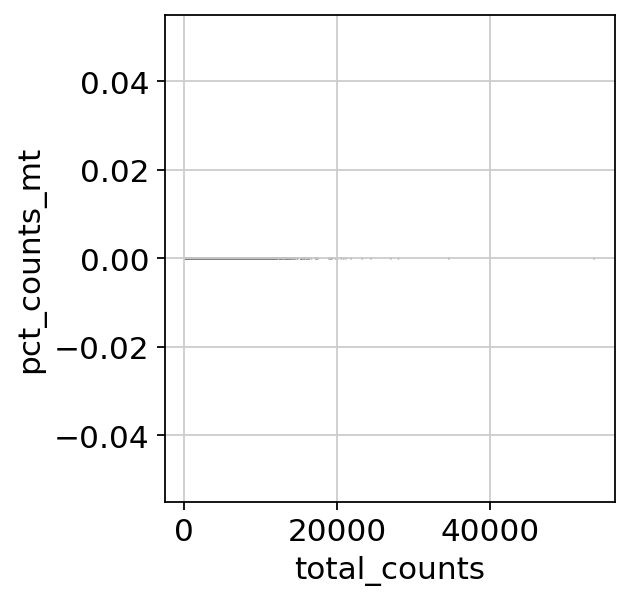

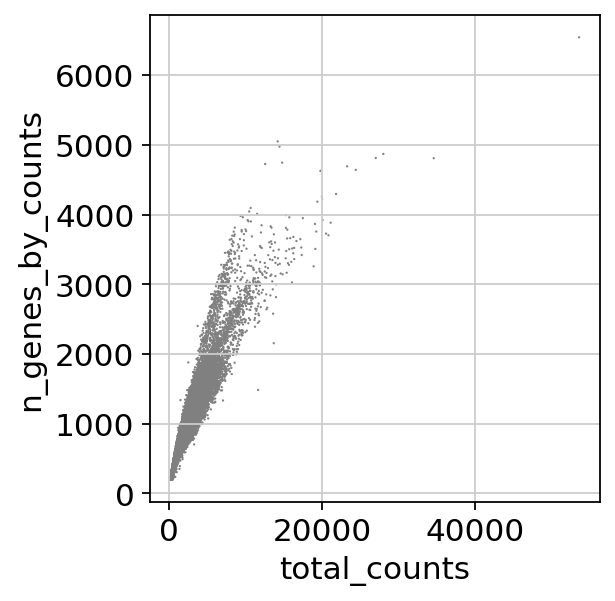

In [25]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [26]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


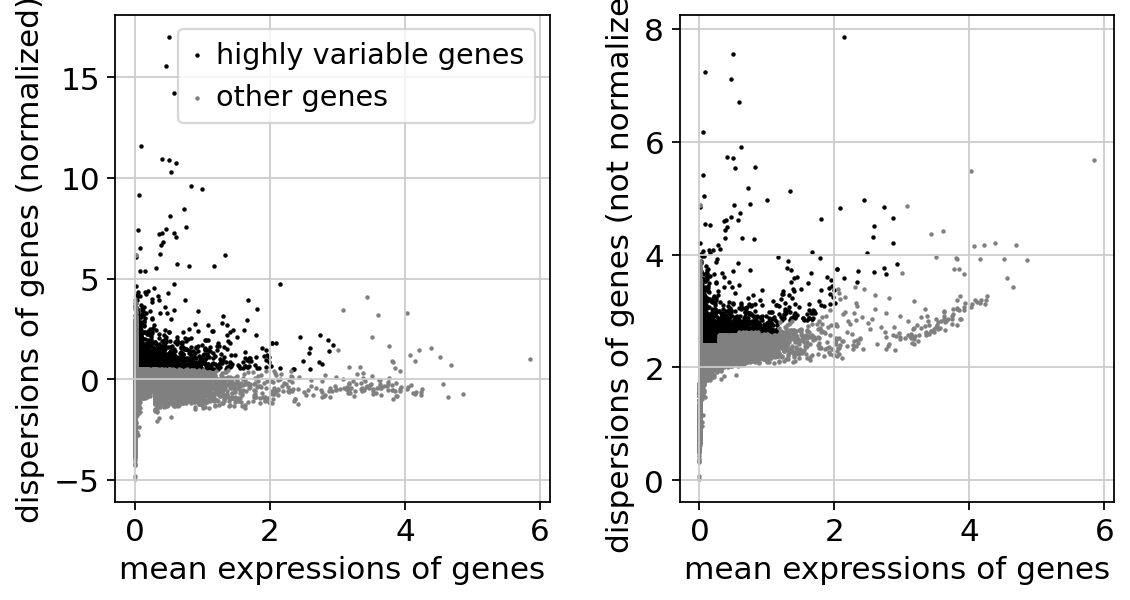

In [28]:
sc.pl.highly_variable_genes(adata)

In [11]:
adata.raw = adata.copy()

In [17]:
adata = adata[:, adata.var.highly_variable]

In [31]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/u/mallina1/envs/torch_jax2/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:01:15)


In [32]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:16)


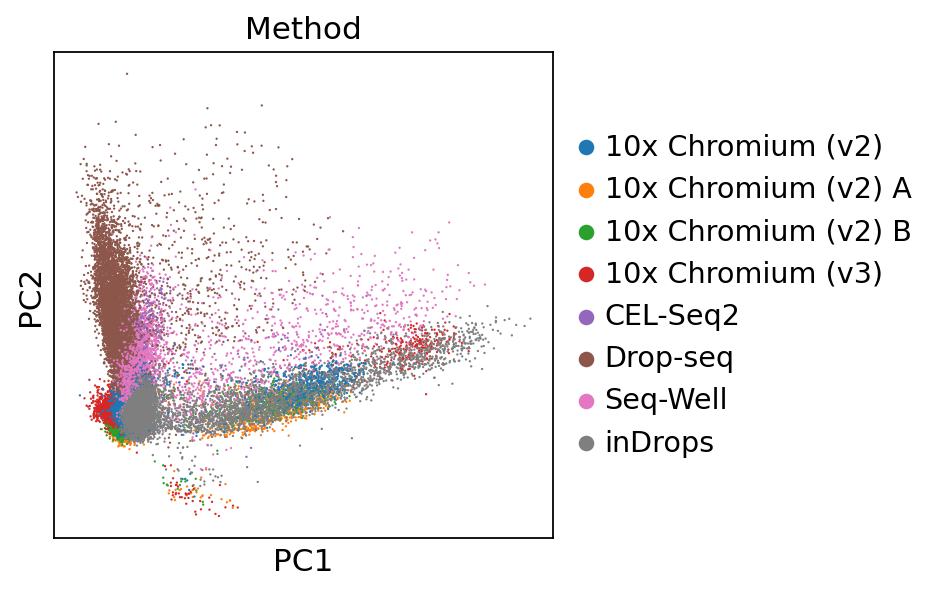

In [34]:
sc.pl.pca(adata, color="Method")

In [18]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


computing neighbors


    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [19]:
sc.tl.leiden(adata, use_weights=True)
# sc.tl.paga(adata)
# sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata)

running Leiden clustering


    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:17)


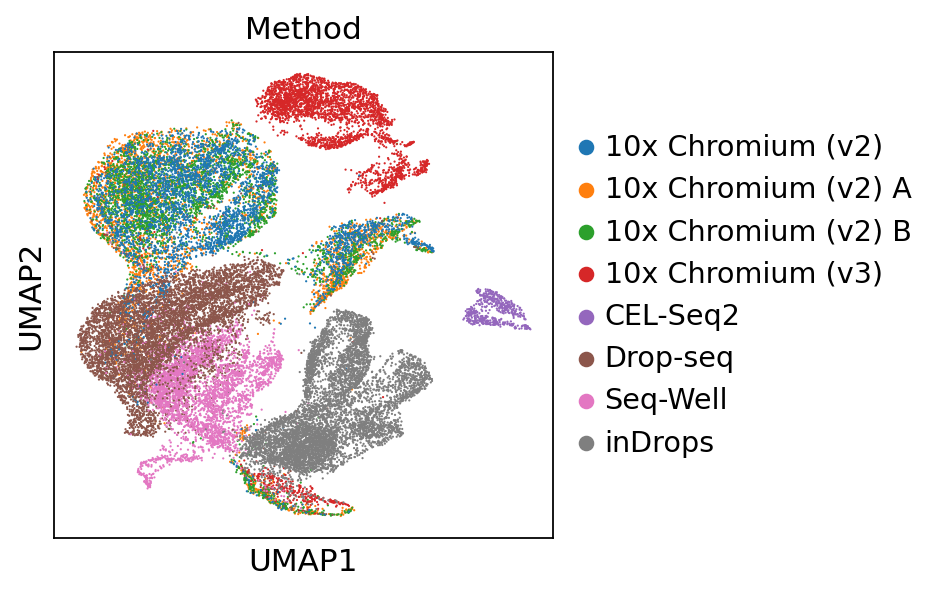

In [22]:
sc.pl.umap(adata, color=["Method"])

In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:18)


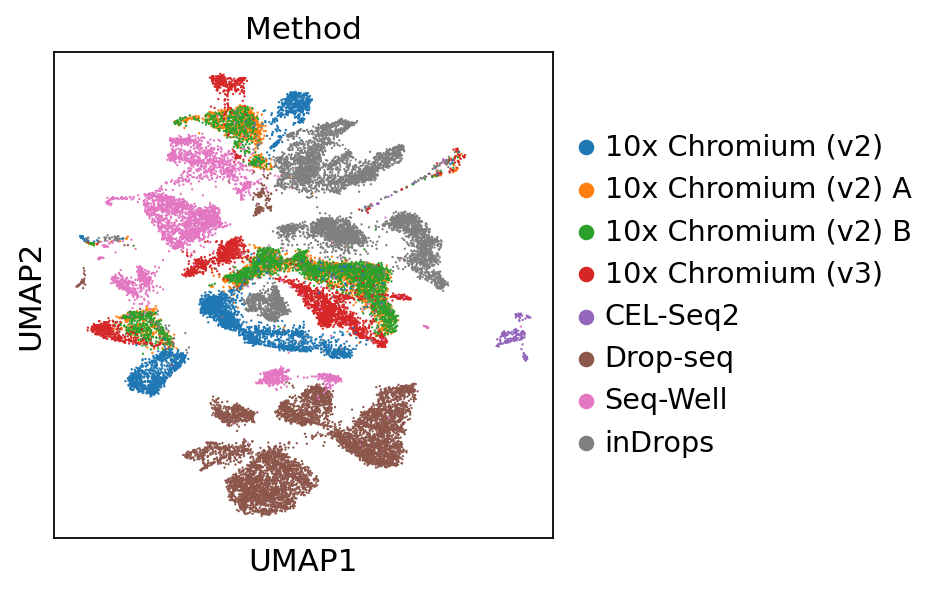

In [42]:
sc.pl.umap(adata, color=["Method"])


In [53]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [ ]:
sc.pl.umap(adata, color=["leiden", "Method", 'CellType'])

In [ ]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')

running PAGA


    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:17)


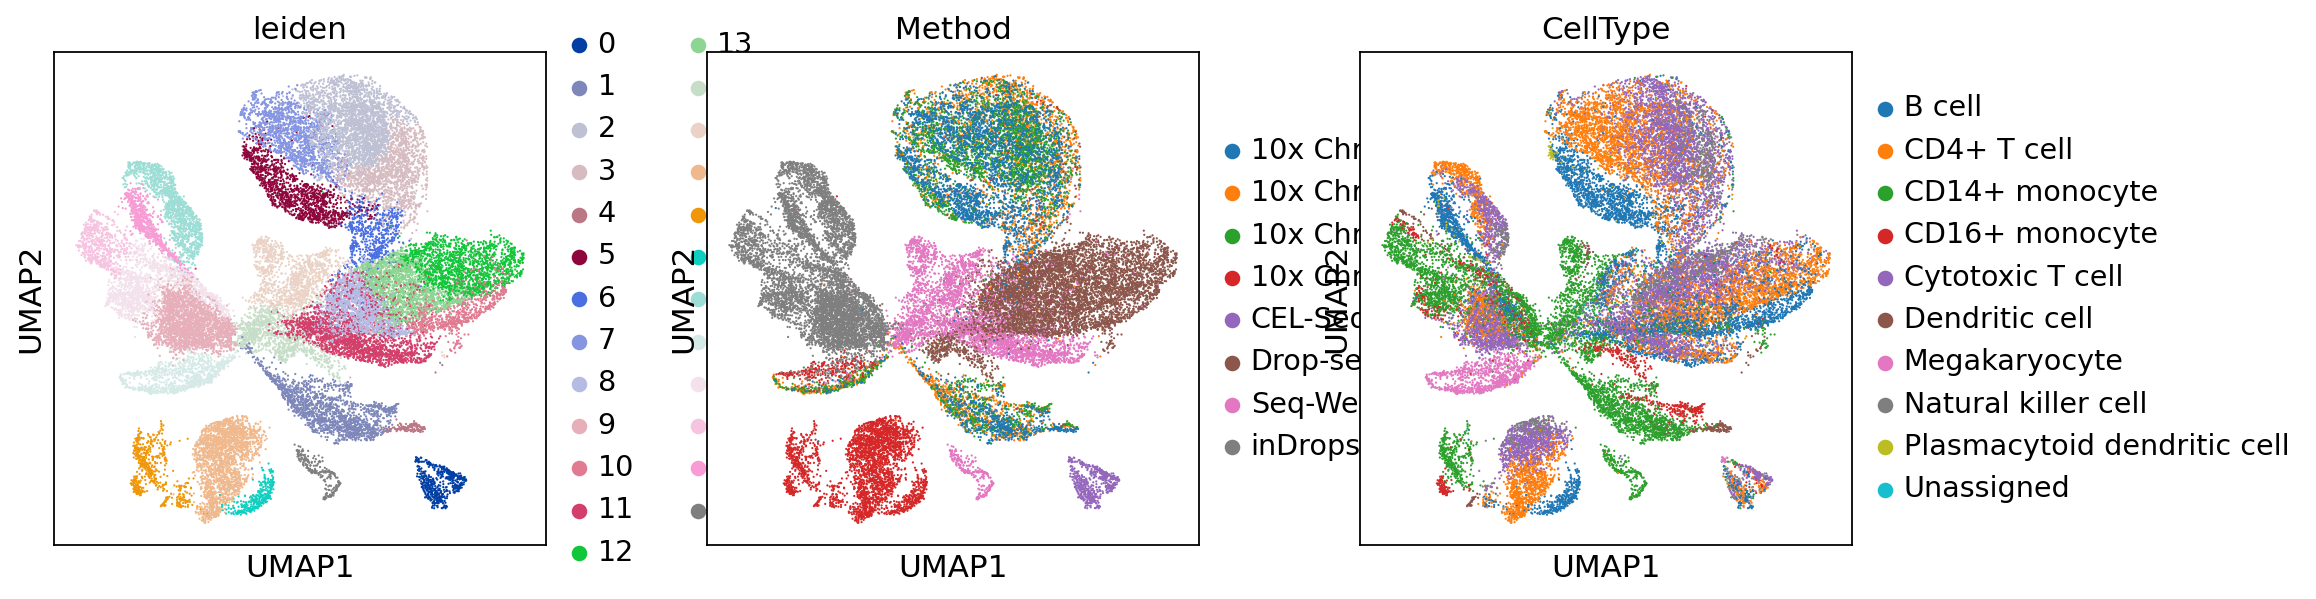

In [ ]:
sc.pl.umap(adata, color=["leiden", "Method", 'CellType'])
